In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import mysql.connector

db = mysql.connector.connect(
    host='localhost',
    username ='root',
    password='@Ajaysaroha@18',
    database='ecommerce'
)
cur = db.cursor()

 # list all unique city where customers are located.    

In [46]:
query = """select distinct(customer_city) from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# count the number of orders placed in 2017

In [ ]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
"Total value placed in 2017", data[0][0]

# finds total sales per category.

In [52]:
query = """ select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df


,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# calculate the percentage of orders that were paid in installments.

In [51]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments"""
cur.execute(query)
data = cur.fetchall()
"the percentage of orders that were paid in installments is ", data[0][0]

('the percentage of orders that were paid in installments is ',
 Decimal('99.9981'))

# count the number of customers from each state.

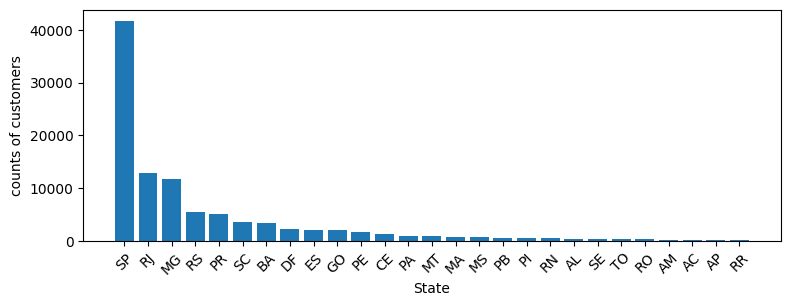

In [50]:
query = """ select customer_state,count(customer_id) from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["State", "Count_of_customers"])
# print(df)
df = df.sort_values(by = "Count_of_customers",ascending=False)
fig = plt.figure(figsize=(9,3))
plt.bar(df["State"], df["Count_of_customers"])
plt.ylabel("counts of customers")
plt.xlabel("State")
plt.xticks(rotation=45)
plt.show()

# calculate the number of orders per month in 2018

      Months  Counts_order
0       July          6292
1     August          6512
2   February          6728
3       June          6167
4      March          7211
5    January          7269
6        May          6873
7      April          6939
8  September            16
9    October             4


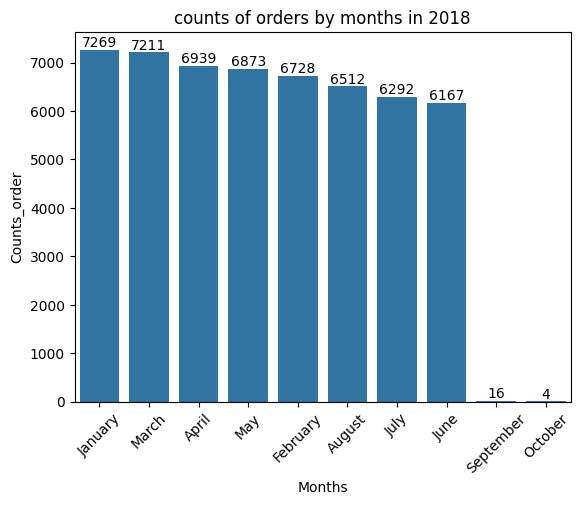

In [49]:
query = """ select monthname(order_purchase_timestamp), count(order_id) from orders
where year(order_purchase_timestamp) = 2018
group by month(order_purchase_timestamp), monthname(order_purchase_timestamp)
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Months", "Counts_order"])
print(df)
df = df.sort_values(by = "Counts_order",ascending=False)
plt.title("counts of orders by months in 2018")
ax = sns.barplot(data=df,x = df["Months"],y = df["Counts_order"])
plt.xticks(rotation=45)
ax.bar_label(ax.containers[0])
plt.show()

# Find the average number of products per order, grouped by customer city.

In [48]:
query = """with count_per_order as
(select ecommerce.orders.order_id, ecommerce.orders.customer_id, count(ecommerce.order_items.order_id) as order_count
from ecommerce.orders join ecommerce.order_items
on ecommerce.order_items.order_id = ecommerce.orders.order_id
group by ecommerce.order_items.order_id, ecommerce.orders.customer_id)

select customers.customer_city, round(avg(count_per_order.order_count),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Cutomer_city", "Average_orders/products"])
df.head(10)



,Cutomer_city,Average_orders/products
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue by each product category.

In [6]:
query = """ select products.product_category,round((sum(payments.payment_value)/(select sum(payments.payment_value) from payments))*100,2) Total_Sales
from order_items join payments
on order_items.order_id = payments.order_id
join products
on order_items.product_id = products.product_id
group by products.product_category order by Total_Sales desc 
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Categories", "Sales%"])
df.head()

,Categories,Sales%
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93


# Identify the correlation between product price and the number of items a product has been purchased.

In [12]:
import numpy as np
query = """ select products.product_category, count(order_items.product_id) order_count, round(avg(order_items.price),2) price_avg
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Category", "order_counts", "price_avg"])
df
arr1 = df["order_counts"]
arr2 = df["price_avg"]
a = np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased", a[0][-1])

the correlation between price and number of times a product has been purchased -0.10631514167157562


# calculate the total revenue generated by each seller, and rank then by revenue.

In [14]:
query = """ select * ,dense_rank() over(order by Revenue desc) as rank_of_seller from
(select order_items.seller_id, round(sum(payments.payment_value),2) Revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Seller_id", "Revenue", "Rank"])
df.head()

,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


# Calculate the moving average of order values for each customer over their order history.

In [3]:
query = """ select customer_id, Time_purchase, payment, round(avg(payment)
over(partition by customer_id order by Time_purchase rows between 2 preceding and current row ),2) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp as Time_purchase, payments.payment_value as payment
from payments join orders
on orders.order_id = payments.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["customer_id", "Time_of_order", "Payments", "Moving_avg"])
df


,customer_id,Time_of_order,Payments,Moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


# Calculate cumulative sales per month for each year.

In [26]:
query = """
    select
        years,
        months, 
        payment,
        sum(payment) 
        over(order by years, months) cumulative_sales
    from
        (select
            year(orders.order_purchase_timestamp) as years,
            month(orders.order_purchase_timestamp) as months,
            round(sum(payments.payment_value),2) as payment
            from payments
            join orders on payments.order_id = orders.order_id
            group by years, months order by years, months) as a """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "Months", "Sales", "Cumulative_Sales"])
df

,Years,Months,Sales,Cumulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate how many customer are interested to sells consistently and how many above and below the moving average

  Trends_label  Counts
0        Equal   99637
1    Above Avg    2065
2    Below Avg    2184


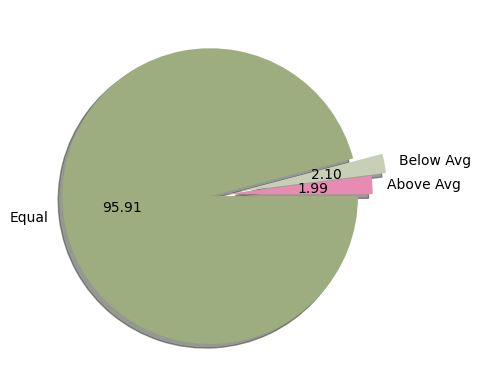

In [53]:
query = """ SELECT 
    trend_label, COUNT(*) AS count
FROM (
    WITH moving_avg AS (
        SELECT 
            customer_id, 
            Time_purchase, 
            payment, 
            ROUND(AVG(payment) OVER (
                PARTITION BY customer_id 
                ORDER BY Time_purchase 
                ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
            ), 2) AS mov_avg
        FROM (
            SELECT 
                orders.customer_id, 
                orders.order_purchase_timestamp AS Time_purchase, 
                payments.payment_value AS payment
            FROM payments 
            JOIN orders ON orders.order_id = payments.order_id
        ) AS a
    )
    SELECT 
        customer_id, 
        Time_purchase, 
        payment, 
        mov_avg,
        CASE 
            WHEN ROUND(payment, 2) < mov_avg THEN 'Below Avg'
            WHEN ROUND(payment, 2) > mov_avg THEN 'Above Avg'
            ELSE 'Equal'
        END AS trend_label
    FROM moving_avg
) AS labeled
GROUP BY trend_label"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns =["Trends_label", "Counts"])
print(df)
group_by = df.groupby("Trends_label")["Counts"].sum()
ex = [0,0.1,0.1]
color = ["#e88bb3","#c7cfb7","#9dad7f"]
plt.pie(group_by.values, labels = group_by.index,autopct = "%.2f",shadow = True,explode=ex,colors=color)
plt.show()

# Calculate the year over year growth rate of total sales.

In [27]:
query = """
WITH cum_sum_payment AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years, 
        ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM payments 
    JOIN orders ON payments.order_id = orders.order_id
    GROUP BY years 
)
SELECT 
    years, 
    payment, 
    LAG(payment) OVER (ORDER BY years) AS previous_year_sales,
    ROUND(
        CASE 
            WHEN LAG(payment) OVER (ORDER BY years) IS NULL THEN NULL
            ELSE ((payment - LAG(payment) OVER (ORDER BY years)) / LAG(payment) OVER (ORDER BY years)) * 100
        END, 2
    ) AS YoY_sales_percent
FROM cum_sum_payment
ORDER BY years;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Year", "Sales", "Previous_Year_Sales", "YoY_Growth_Percent"])
df


,Year,Sales,Previous_Year_Sales,YoY_Growth_Percent
0,2016,59362.34,NaN,NaN
1,2017,7249746.73,59362.34,12112.7
2,2018,8699763.05,7249746.73,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first puchase.

In [30]:
query  = """ WITH customer_first_order AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM orders 
    JOIN customers ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),
customer_next_order AS (
    SELECT 
        o.customer_id
    FROM orders o
    JOIN customer_first_order cfo 
        ON o.customer_id = cfo.customer_id
    WHERE o.order_purchase_timestamp > DATE_ADD(cfo.first_order, INTERVAL 6 MONTH)
    GROUP BY o.customer_id
)
SELECT 
    ROUND(
        100.0 * COUNT(DISTINCT customer_next_order.customer_id) / COUNT(DISTINCT customer_first_order.customer_id),
        2
    ) AS retention_after_6_months_percent
FROM customer_first_order
LEFT JOIN customer_next_order 
    ON customer_first_order.customer_id = customer_next_order.customer_id"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["retention_after_6_months_percent"])
df

,retention_after_6_months_percent
0,0.00


# identify the top 3 customers who spent the most money in each year.

In [31]:
query = """ select years, customer_id, payment, customer_rank from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) customer_rank
from orders join payments
on payments.order_id = orders.order_id
group by  year(orders.order_purchase_timestamp),orders.customer_id) as a
where customer_rank <= 3"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Years","Customer_id", "Sales","Rank"])
df

,Years,Customer_id,Sales,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3
